# Wet and dry days
 
Highlights 

- While variability is high, there has been little change in annual total rainfall observed in the meteorological station at Koror over the last {glue:text}`n_years:.0f` years   

- There has been little change in both in dry and wet conditions, exhibiting no statistically significant trend over the period 1951 to 2024.   

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys
import folium

from myst_nb import glue 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs
from ind_setup.colors import get_df_col
from ind_setup.core import fontsize
from ind_setup.tables import plot_df_table, table_rain_a_summary


sys.path.append("../../../functions")
from data_downloaders import GHCN

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

## Get Data

In [3]:
update_data = False
path_data = "../../../data"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

## Using Koror Station

In [5]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

Analysis of wet days

In [6]:
dict_prcp = [{'data' : data, 'var' : 'PRCP', 'ax' : 1, 'label' : 'Precipitation'}, ]

## Wet days

Wet days are considered when rainfall is above 1mm

In [7]:
data = dict_prcp[0]['data']#.dropna()
data = data.groupby(data.index.year).filter(lambda x: len(x) >= 300).dropna()

glue("n_years", len(np.unique(data.index.year)), display=False)


In [8]:
data['wet_day'] = np.where(data['PRCP'] > 1, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

Text(0, 0.5, 'Number of Days')

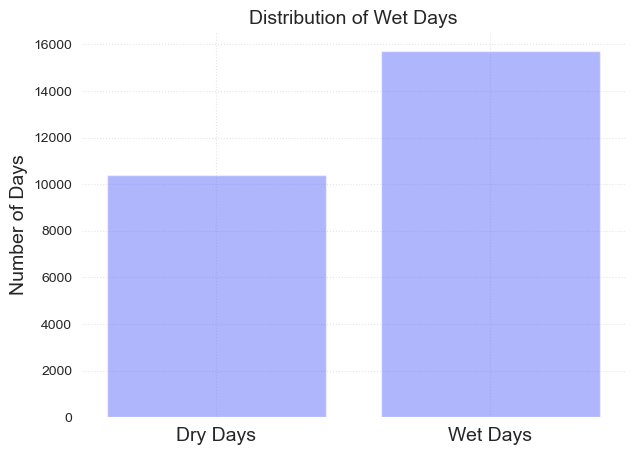

In [9]:
fig, ax = plot_bar_probs(x = [0, 1], y = data.groupby('wet_day').count()['PRCP'].values, labels = ['Dry Days', 'Wet Days'])
ax.set_title('Distribution of Wet Days', fontsize = fontsize)
ax.set_ylabel('Number of Days', fontsize = fontsize)    

## Accumulated precipitation

In [10]:
# Correct accumulated precipitation with number of observations per year to make fair comparisons and trends
datag = (data.groupby(data.index.year).sum()/ data.groupby(data.index.year).count()) * 365
datag.index = pd.to_datetime(datag.index, format = '%Y')
dict_plot = [{'data' : datag, 'var' : 'PRCP', 'ax' : 1, 'label':'Accumulated precipitation [mm]'},]

Text(0, 0.5, 'Accumulated Rainfall [mm]')

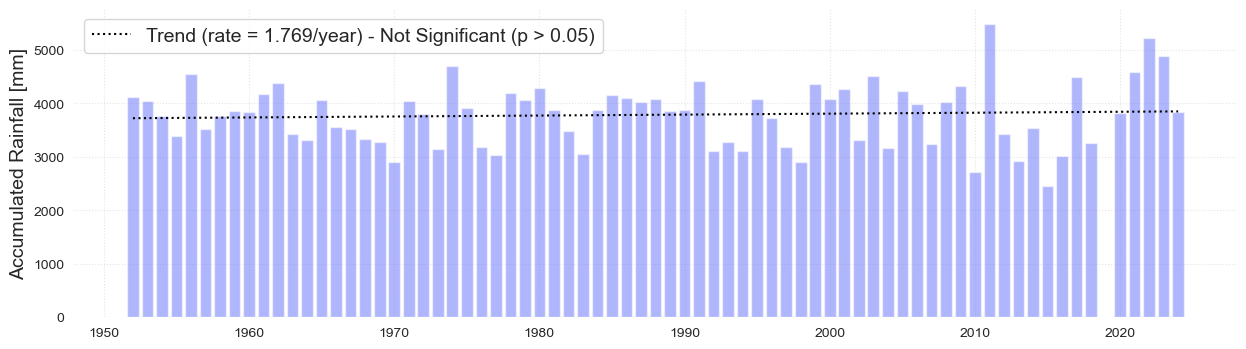

In [11]:
fig, ax = plot_bar_probs(x = datag.index.year, y = datag['PRCP'].values,
                    trendline = True, figsize = [15, 4])
ax.set_ylabel('Accumulated Rainfall [mm]', fontsize = fontsize)


## Number of days over and above 1mm threshold

In [12]:
threshold = 1 #np.percentile(data['PRCP'].dropna(), 90)
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

In [13]:
data_th = data.groupby([data.index.year, data.wet_day_t]).count()['PRCP']
data_th = data_th/data.groupby(data.index.year).count()['PRCP'] * 365

Text(0, 0.5, 'Number of days')

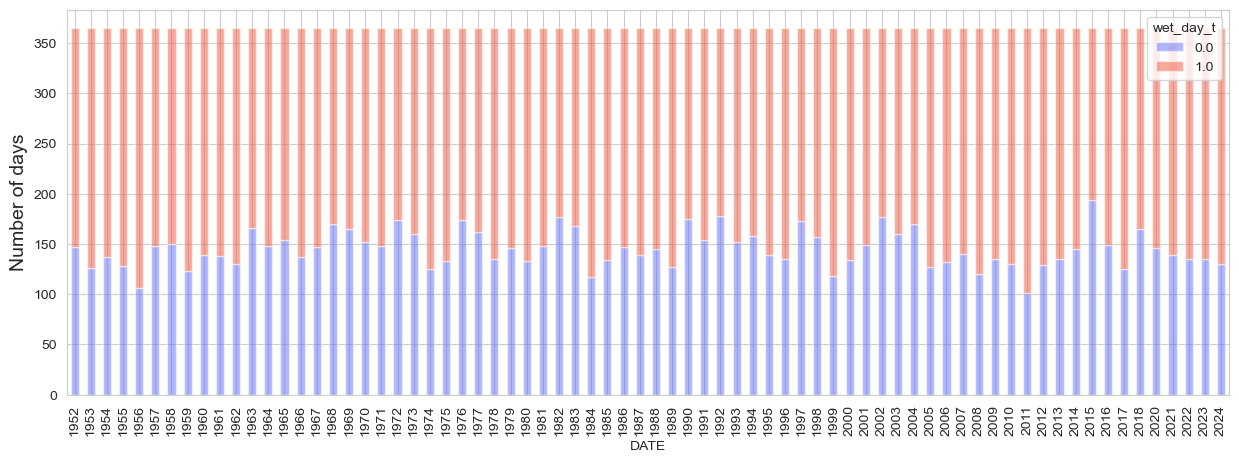

In [14]:
fig, ax = plt.subplots(figsize = [15, 5])
data_th.unstack().plot(kind = 'bar', stacked = True, ax = ax, color = get_df_col()[:2], edgecolor = 'white', alpha = .5)
ax.set_ylabel('Number of days', fontsize = fontsize)

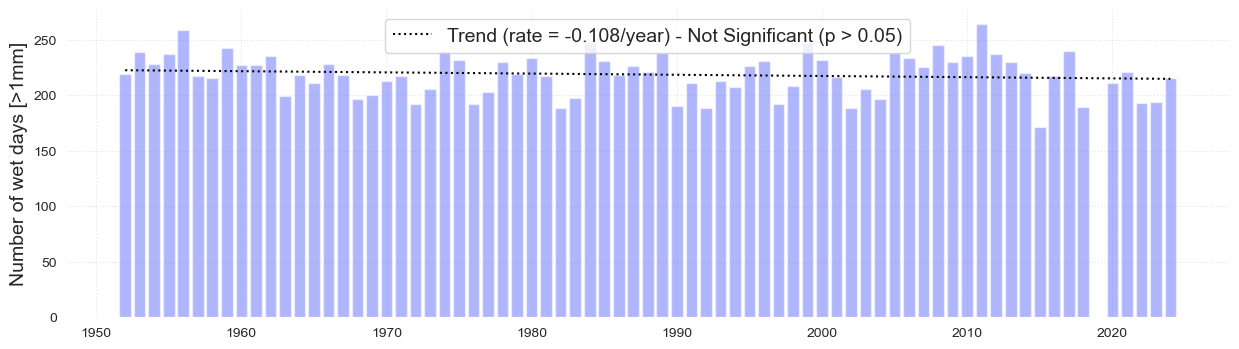

In [15]:
#Wet days
data2 = data.loc[data['wet_day_t'] == 1]
data2 = data2.groupby(data2.index.year).count()
fig, ax, trend = plot_bar_probs(x = data2.index, y = data2.PRCP.values, trendline = True,
               y_label = 'Number of wet days [>1mm]', figsize = [15, 4], return_trend = True)

glue("trend_wet", float(trend), display=False)


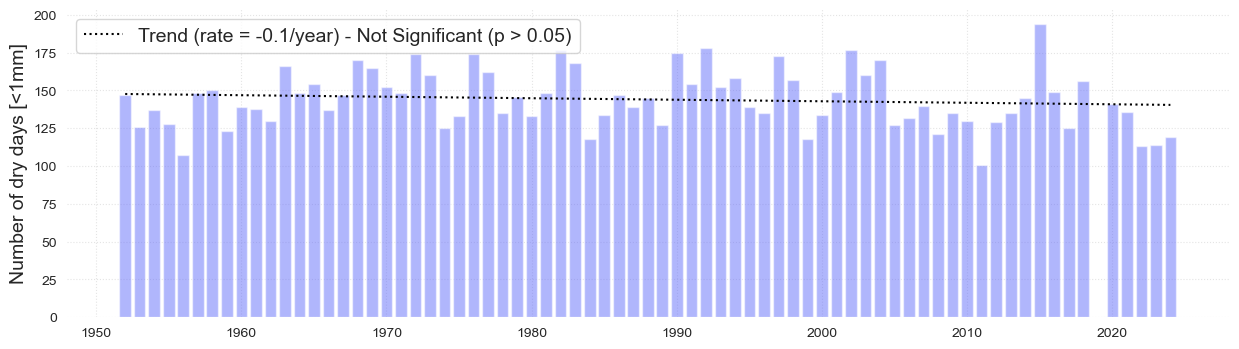

In [16]:
#Dry days
data2 = data.loc[data['wet_day_t'] == 0]
data2 = data2.groupby(data2.index.year).count()
fig, ax, trend = plot_bar_probs(x = data2.index, y = data2.PRCP.values, trendline = True,
               y_label = 'Number of dry days [<1mm]', figsize = [15, 4], return_trend = True)
glue('trend_dry', float(trend), display=False)


## Days over 95 threshold

In [17]:
prcentile = 95
threshold = np.round(np.percentile(data['PRCP'].dropna(), prcentile), 2)
print(f'Threshold of {threshold}mm')
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

Threshold of 45.7mm


In [18]:
data_2 = data.loc[data['wet_day_t'] == 1][['PRCP']]
data_over_th = data_2.groupby(data_2.index.year).count()
data_over_th.index = pd.to_datetime(data_over_th.index, format = '%Y')


In [19]:
data_over_th['PRCP_below'] = 365 - data_over_th['PRCP'].values

In [20]:
dict_plot = [{'data' : data_over_th, 'var' : 'PRCP', 'ax' : 1, 'label':f'Number of days over threshold: {threshold}mm'},]

(<Figure size 1500x500 with 1 Axes>,
 <Axes: ylabel='Number of days over 95 percentile'>)

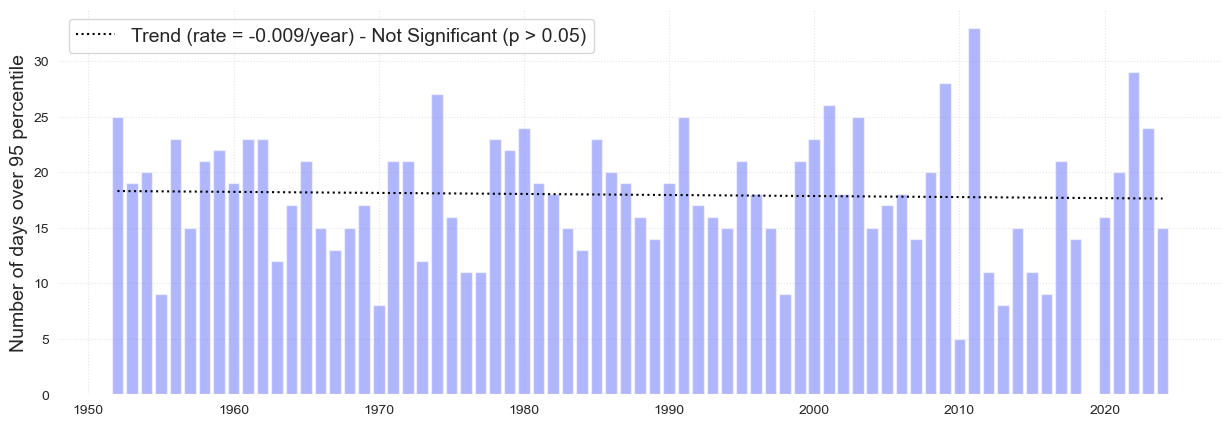

In [21]:
plot_bar_probs(x = data_over_th.index.year, y = data_over_th['PRCP'].values, trendline = True,
               figsize = (15, 5), y_label = f'Number of days over {prcentile} percentile')

## Annual maxima

In [22]:
data_max = data.groupby(data.index.year).max()
data_max.index = pd.to_datetime(data_max.index, format = '%Y')

dict_plot = [{'data' : data_max, 'var' : 'PRCP', 'ax' : 1, 'label':'Annual daily maxima'},]
plot_timeseries_interactive(dict_plot, trendline = True, figsize = (25, 12), label_yaxes = 'Precipitation [mm]');

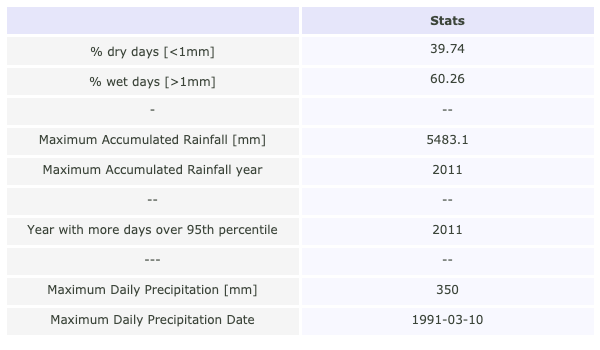

In [23]:
df = table_rain_a_summary(data)
fig = plot_df_table(df.T, figsize = (600, 350),)